In [3]:
import requests
import urllib.request, json 

import requests, io, cv2
import numpy as np
from PIL import Image

import torch 
import os 
import zipfile 
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import layers 
from tensorflow.keras import Model 
import matplotlib.pyplot as plt

from tensorflow.keras.applications.vgg16 import VGG16
import cv2
import numpy as np

from concurrent.futures import ThreadPoolExecutor, as_completed


import numpy as np
from sklearn.decomposition import PCA

from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import numpy as np

import sklearn

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [71]:
product_url = "https://raw.githubusercontent.com/chenlh0/product-classification-challenge/master/product_data.json"
with urllib.request.urlopen(product_url) as url:
  product_data = json.loads(url.read().decode())

product_list_url = "https://raw.githubusercontent.com/chenlh0/product-classification-challenge/master/product_categories.txt"
r = requests.get(product_list_url, allow_redirects=True)
product_types = r.content.decode('utf-8').strip("\n").split("\n")

In [ ]:
# cluster then manually label one from each cluster

In [107]:
# load descriptions

#raw_images = []
raw_descriptions = []
for entry in product_data[:]:
  desc = entry['description']
  #image_url = entry['image_url']
  #response = requests.get(image_url)
  #bytes_im = io.BytesIO(response.content)
  #im=Image.open(bytes_im).resize((224,224))
  #image_ndarray = cv2.cvtColor(np.array(im), cv2.COLOR_RGB2BGR)
  #raw_images.append(image_ndarray)
  raw_descriptions.append(desc)

In [96]:
# concurrently get images and resize to 224x224x3
image_urls = []
for entry in product_data[:]:
  image_url = entry['image_url']
  image_urls.append(image_url)
  
def download_file(url):
    try:
        #html = requests.get(url, stream=True)
        response = requests.get(url, stream=True)
        bytes_im = io.BytesIO(response.content)
        im=Image.open(bytes_im).resize((224,224))
        image_ndarray = cv2.cvtColor(np.array(im), cv2.COLOR_RGB2BGR)
        return image_ndarray
        #return html.status_code
    except requests.exceptions.RequestException as e:
       return e
 
def runner():
  images = []
  with ThreadPoolExecutor(max_workers=20) as executor:
    images = executor.map(download_file, image_urls)
  return list(images)

images = runner()

In [87]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [105]:
images_path = "drive/MyDrive/product_classification/raw_images.npy"
descriptions_path = "drive/MyDrive/product_classification/raw_descriptions.npy"

In [108]:
#np.save(images_path, images)
#np.save(descriptions_path, raw_descriptions)

In [111]:
images = np.load(images_path, allow_pickle=True)
descriptions = np.load(descriptions_path, allow_pickle=True)

In [109]:
# reference: https://www.analyticsvidhya.com/blog/2020/08/top-4-pre-trained-models-for-image-classification-with-python-code/
# load VGG16 pretrained image classification model
base_model = VGG16(input_shape = (224, 224, 3), # Shape of our images
                   include_top = False, # Leave out the last fully connected layer
                   weights = 'imagenet')

# Since we don’t have to train all the layers, we make them non_trainable:
for layer in base_model.layers:
  layer.trainable = False

# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss = 'binary_crossentropy',metrics = ['acc'])

In [112]:
image_embeddings = model.predict(images/255.)

In [121]:
# generate image embedding from VGG16
#image_embeddings = model.predict(images/255.)

# reduce to lower dimension
pca = PCA(n_components=100, whiten=False)
image_embeddings_pca = pca.fit_transform(image_embeddings)

In [123]:
pca.explained_variance_ratio_

array([0.07588611, 0.0561543 , 0.02859374, 0.02203032, 0.02032207,
       0.01811742, 0.01498312, 0.01291567, 0.01191125, 0.01125498,
       0.01054256, 0.00964739, 0.00907156, 0.00881596, 0.00845972,
       0.00794146, 0.0078981 , 0.00759687, 0.00745014, 0.00691897,
       0.00677519, 0.00660865, 0.00641339, 0.00604043, 0.00578807,
       0.00562739, 0.00546223, 0.00535365, 0.00516209, 0.00505629,
       0.00493599, 0.0047833 , 0.00458193, 0.00444244, 0.00436393,
       0.0043043 , 0.00421509, 0.00405126, 0.00401248, 0.00396617,
       0.00383204, 0.00378311, 0.00372916, 0.00368876, 0.00357692,
       0.00348597, 0.00338728, 0.00331742, 0.00328973, 0.00323868,
       0.00317816, 0.00314943, 0.0030057 , 0.00299012, 0.00295523,
       0.00289546, 0.00286693, 0.00284618, 0.00282165, 0.00273592,
       0.00269378, 0.00264067, 0.00262785, 0.00261469, 0.00258022,
       0.00253844, 0.00251408, 0.00248072, 0.00243   , 0.00239973,
       0.00238904, 0.00236387, 0.00232069, 0.00229277, 0.00226

In [131]:
image_embeddings_pca[0].shape

(100,)

In [128]:
images_embedding_path = "drive/MyDrive/product_classification/images_embedding.npy"
descriptions_embedding_path = "drive/MyDrive/product_classification/descriptions_embedding.npy"

In [129]:
#np.save(images_embedding_path, image_embeddings_pca)
#np.save(descriptions_path, descriptions_embedding_path)

In [6]:
image_embeddings = np.load(images_embedding_path, allow_pickle=True)
descriptions_embeddings = np.load(descriptions_embedding_path, allow_pickle=True)

In [133]:
# doc2vec text embedding
# resource: https://www.analyticsvidhya.com/blog/2020/08/top-4-sentence-embedding-techniques-using-python/
def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

In [134]:
def tag_desc(desc):
  x = desc.strip()
  tokens = word_tokenize(x.lower())
  #tokens = [x for x in tokens if x not in ("", ",", )]
  return tokens
tokenized_descriptions = list(map(tag_desc, raw_descriptions))

In [146]:
## Train doc2vec model
tagged_data = [TaggedDocument(d, [i]) for i, d in enumerate(tokenized_descriptions)]
#vector_size = Dimensionality of the feature vectors.
#window = The maximum distance between the current and predicted word within a sentence.
#min_count = Ignores all words with total frequency lower than this.
#alpha = The initial learning rate.
model = Doc2Vec(tagged_data, vector_size=100, window=3, min_count=5, epochs=100)

In [147]:
descriptions_embeddings_ = []
for tokenized_desc in tokenized_descriptions:
  descriptions_embeddings_.append(model.infer_vector(tokenized_desc))
descriptions_embedings = np.stack(descriptions_embeddings_, axis=0)

In [149]:
descriptions_embedings.shape

(1000, 100)

In [150]:
np.save(descriptions_embedding_path, descriptions_embedings)

In [ ]:
#test_doc = word_tokenize("I had pizza and pasta".lower())
#test_doc_vector = model.infer_vector(test_doc)
#model.docvecs.most_similar(positive = [test_doc_vector])

In [173]:
# combine the two embeddings
images_path = "drive/MyDrive/product_classification/raw_images.npy"
descriptions_path = "drive/MyDrive/product_classification/raw_descriptions.npy"
image_embeddings = np.load(images_embedding_path, allow_pickle=True)
descriptions_embeddings = np.load(descriptions_embedding_path, allow_pickle=True)
#print(image_embeddings.shape)
#print(descriptions_embeddings.shape)

# concat
combined_embedding = np.concatenate((image_embeddings, descriptions_embeddings), axis=1)
# normalize 
combined_embedding_normalized = sklearn.preprocessing.normalize(combined_embedding)
print(combined_embedding_normalized.shape)

(1000, 100)
(1000, 100)
(1000, 200)


In [183]:
product_types

['TOPS',
 'DRESS',
 'PANT',
 'SKIRT',
 'SHORTS',
 'LINGERIE',
 'OUTERWEAR',
 'JUMPSUIT',
 'JEWELRY',
 'BAG',
 'SHOE',
 'OTHERS']

In [180]:
# cluster embeddings
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=len(product_types), random_state=0).fit(combined_embedding_normalized)

In [ ]:
# group the inputs by label
clusters = [[] for _ in range(len(product_types))]
for idx, label in enumerate(kmeans.labels_):
  clusters[label].append(idx)
clusters[0]

In [236]:
# get original images
image_urls = []
for entry in product_data[:]:
  image_url = entry['image_url']
  image_urls.append(image_url)
  
def download_file(url):
    try:
        #html = requests.get(url, stream=True)
        response = requests.get(url, stream=True)
        bytes_im = io.BytesIO(response.content)
        im=Image.open(bytes_im)
        return im
    except requests.exceptions.RequestException as e:
       return e
 
def runner():
  images = []
  with ThreadPoolExecutor(max_workers=20) as executor:
    images = executor.map(download_file, image_urls)
  return list(images)

original_images = runner()

#%pylab inline
def describe(idx):
  print(raw_descriptions[idx])
  print("-"*30)
  fig = figure(figsize=(10, 10), dpi=80)
  imgplot = plt.imshow(original_images[idx])
  fig.show()

In [271]:
# manually review a few samples per cluster
label_to_clusters = {
  'TOPS' : 5,
  'DRESS' : 6,
  'PANT' : 4,
  'SKIRT' : 9,
  'SHORTS' : 8,
  'LINGERIE' : 2,
  'OUTERWEAR' : 1,
  'JUMPSUIT' : 7,
  'JEWELRY' : 3,
  'BAG' : 10,
  'SHOE' : 11,
  'OTHERS' : 0,
}

Faux-saffiano leather, Leaf print, Inner lining, Upper zip fastening, Logo detail
------------------------------
Upper: suede and glitter Leather lining Leather sole 100 mm heel
------------------------------
Upper: suede Ankle strap 45 mm woven cord platform with rubber sole
------------------------------
Calf leather Detachable leather shoulder strap Detachable multicolored fabric shoulder strap Gold-plated hardware Metal lettering logo Two compartments with zipper closure Prada logo lining
------------------------------
Upper: leather Applied crystals 75 mm rubber sole Leather lining
------------------------------
Medium, Mesh design, Short metallic handles, Long adjustable strap, Incorporated cosmetic bag, Inner pocket, Strap fastening
------------------------------


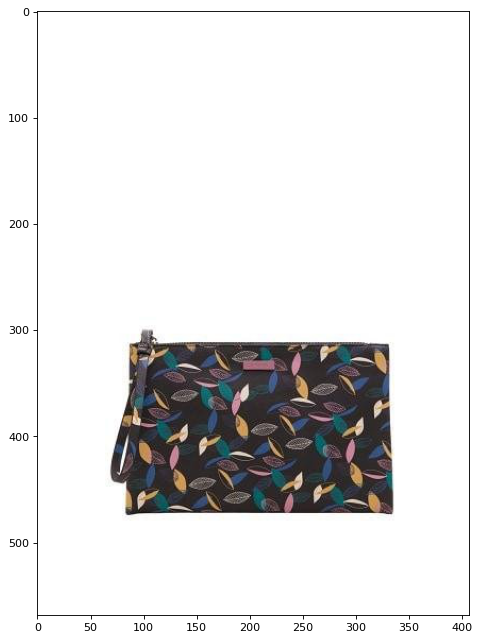

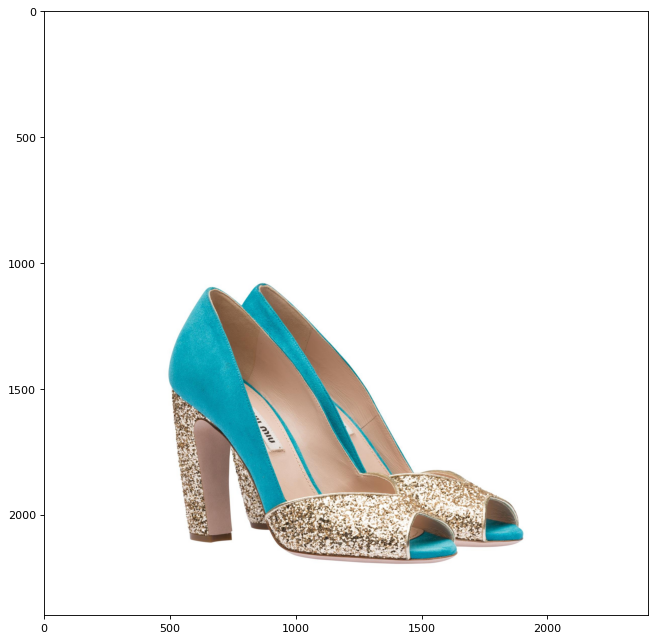

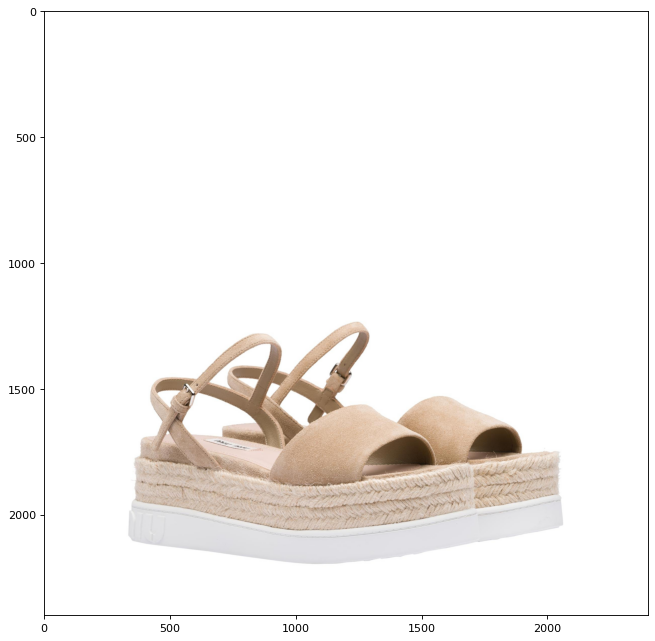

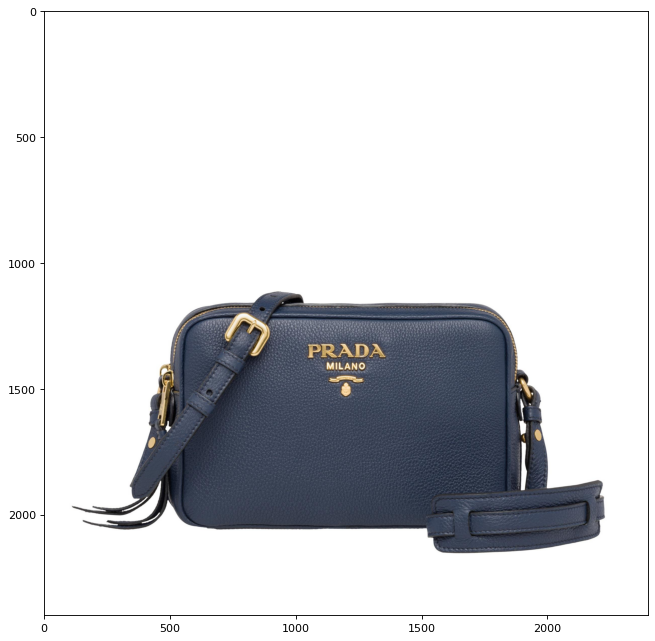

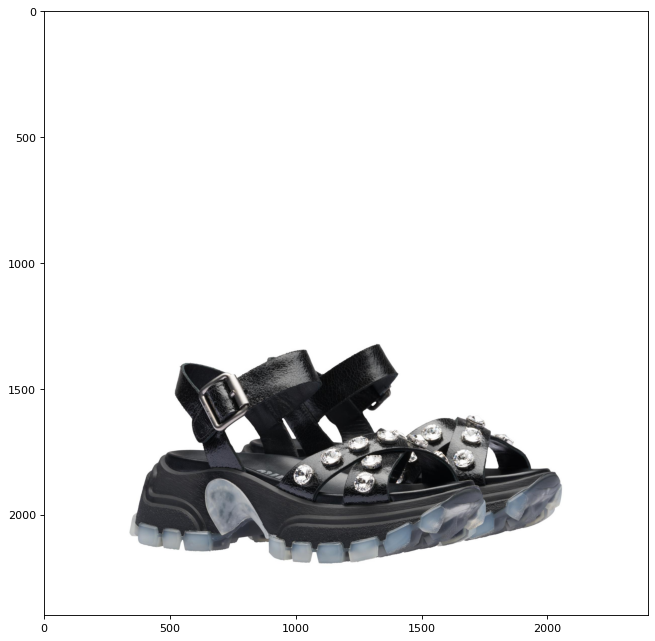

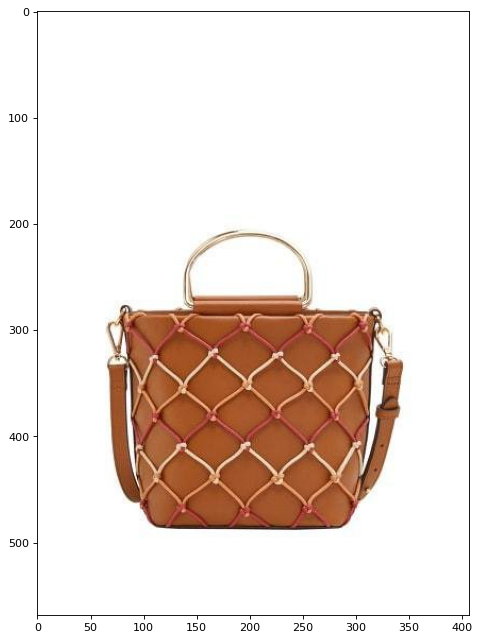

In [264]:
for idx in clusters[0][0:6]:
  describe(idx)

In [284]:
product_url = "https://raw.githubusercontent.com/chenlh0/product-classification-challenge/master/product_data.json"
with urllib.request.urlopen(product_url) as url:
  product_data = json.loads(url.read().decode())
cluster_to_label = {v:k for k, v in label_to_clusters.items()}
for i in range(1000):
  product_data[i]['label'] = cluster_to_label[kmeans.labels_[i]]

In [288]:
import json
with open('drive/MyDrive/product_classification/output.json', 'w', encoding='utf-8') as f:
  json.dump(product_data, f, ensure_ascii=False, indent=4)

In [ ]:
# README
This code embeds the images and text, then runs KMeans clustering. A manual review of a few samples from each cluster is done to assign labels to each cluster.

To get the image embedding, we prepare the images by rescaling them, then use VGG16 pretrained on imagenet, then apply PCA to reduce to 100 dimensions.
To get text embedding, we use doc2vec to get 100 dimensional embedding.
We then concat the embeddings, normalize, and run clustering.

In [ ]:
Upload the followings to Github:
- Code with README file
- Classification results for all 1000 fashion products added to the input json file
- Answers to the following questions:

- Why are you designing the solution in this way?
    Because the dataset is small, we want to use transfer learning for both images and text.

- What are the aspects that you considered when designing?
    Scalability, if the number of samples we want to classify go up,
    we should be able to still classify them without having to do much extra work.
    If all we ever want is to classify 1k samples, this could probably even be done 
    manually.


- What are the cases your solution covers, how are they covered and why are they
important?
  This solution allows classifying new samples as they come in, without having to do any additional work.

- What are the cases your solution does not cover and what are the ways you can
extend your current solution for them?
  If the number of product categories changes, then we would have to repeat this exercise and redo the manual labeling.